# **Churn Prediction 'Die ZEIT' - Baseline**
### **Used Libraries**

In [1]:
# Basic packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Individual functions
import functions_models as mdl

# Scaling modules
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# SUPERVISED LEARNING
# Libraries for classification issues
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Libraries for classification and regression issues
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Libraries for splitting data, hyperparameter tuning & Pipeline
from sklearn.model_selection import train_test_split

# Librarie for data balancing (sampling)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Display the whole content of the data frame (all columns and rows)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Define decimal places shown in the notebook
pd.options.display.float_format = '{:,.2f}'.format

# Visualization
%matplotlib inline
sns.set_style('whitegrid')

# Ignore warnings while plotting
import warnings
warnings.filterwarnings("ignore")

### **Settings**

In [2]:
RSEED = 42
TEST_SIZE = 0.3
PATH = '00_plots/'

### **Read Data**

In [3]:
df = pd.read_csv('00_data/f_chtr_churn_traintable_nf.csv')

### **Data insight**

In [4]:
# Numeric and categorical features
shape_init_rows = df.shape[0]
shape_init_cols = df.shape[1]

print('The shape of the data set:\n{0} rows\n{1} columns\n'.format(shape_init_rows, shape_init_cols))
print('='*25)
cont_f = df.select_dtypes(include=['float64', 'int64'])
print('Numeric features: {0}'.format(len(cont_f.columns)))
cat_f = df.select_dtypes(include="object")
print('Objectlike features: {0}'.format(len(cat_f.columns)))

The shape of the data set:
209043 rows
171 columns

Numeric features: 153
Objectlike features: 18


## **1 - Data Preprocessing for Modeling**
### **Drop Irrelevant Features**

In [5]:
df.drop(columns=['Unnamed: 0',
                 'auftrag_new_id',
                 'kuendigungs_eingangs_datum',
                 'avg_churn',
                 'training_set'], inplace=True)

### **Drop Redundant Features**

In [6]:
df.drop(columns=['ort',
                 'plz_1',
                 'plz_2'], inplace=True)

### **Dealing with Missing Values**

In [7]:
df.isna().sum().sort_values().tail()

opened_anzahl_3m       0
openedanzahl_6m        0
received_anzahl_1w     0
date_x                 0
email_am_kunden       12
dtype: int64

In [8]:
df.dropna(subset=['email_am_kunden'], inplace=True)

### **Summary**

In [9]:
# Numeric and categorical features
shape_a_nan_rows = df.shape[0]
shape_a_nan_cols = df.shape[1]

print('The shape of the data set (after dealing with missing values):\n\n{0} rows \n{1} columns\n'.format(shape_a_nan_rows, shape_a_nan_cols))
print('='*25)
print('By dropping the rows containing missing values -- {0} % -- of the rows got removed\n(compared to the inital data set).\n'
      .format(round(((shape_init_rows-shape_a_nan_rows)/shape_init_rows)*100, ndigits=3)))
print('='*25)
print('Features after dropping columns:\n')
cont_f = df.select_dtypes(include=['float64', 'int64'])
print('Numeric features: {0}'.format(len(cont_f.columns)))
cat_f = df.select_dtypes(include="object")
print('Objectlike features: {0}'.format(len(cat_f.columns)))

The shape of the data set (after dealing with missing values):

209031 rows 
163 columns

By dropping the rows containing missing values -- 0.006 % -- of the rows got removed
(compared to the inital data set).

Features after dropping columns:

Numeric features: 150
Objectlike features: 13


### **Dealing with DTypes and Dummies**
#### **Reformating zon_* columns**

In [10]:
zon_columns = ['zon_che_opt_in', 'zon_sit_opt_in', 'zon_zp_grey', 
               'zon_premium', 'zon_boa', 'zon_kommentar', 
               'zon_sonstige', 'zon_zp_red', 'zon_rawr', 
               'zon_community', 'zon_app_sonstige', 'zon_schach', 
               'zon_blog_kommentare', 'zon_quiz'
              ]

zon_columns_ind = []

for col in zon_columns:
    ind = df.columns.get_loc(col)
    zon_columns_ind.append(ind)

for i in df.iloc[: , lambda df: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]:
    df[i] = df[i].apply(mdl.todumm)

#### **DType Conversions**

In [11]:
# Create list with categorical features and converting them -->> dtype = category
category_features = ['kanal',
                     'objekt_name',
                     'aboform_name',
                     'zahlung_rhythmus_name',
                     'zahlung_weg_name',
                     'land_iso_code',
                     'anrede',
                     'titel',
                     'email_am_kunden'
                    ]

df[category_features] = df[category_features].astype('category')

In [12]:
# Convert columns with dates -->> dtype = datetime
df['liefer_beginn_evt'] = pd.to_datetime(df['liefer_beginn_evt'])
df['abo_registrierung_min'] = pd.to_datetime(df['abo_registrierung_min'])
df['nl_registrierung_min'] = pd.to_datetime(df['nl_registrierung_min'])
df['date_x'] = pd.to_datetime(df['date_x'])

In [13]:
# Creating new columns for datelike features (year & month)
df['liefer_beginn_evt_year'] = df['liefer_beginn_evt'].dt.strftime('%Y')
df['liefer_beginn_evt_month'] = df['liefer_beginn_evt'].dt.strftime('%m')

df['abo_registrierung_min_year'] = df['abo_registrierung_min'].dt.strftime('%Y')
df['abo_registrierung_min_month'] = df['abo_registrierung_min'].dt.strftime('%m')

df['nl_registrierung_min_year'] = df['nl_registrierung_min'].dt.strftime('%Y')
df['nl_registrierung_min_month'] = df['nl_registrierung_min'].dt.strftime('%m')

df['date_x_year'] = df['date_x'].dt.strftime('%Y')
df['date_x_month'] = df['date_x'].dt.strftime('%m')

In [14]:
# Dropping original datelike columns
df.drop(columns=['liefer_beginn_evt',
                 'abo_registrierung_min',
                 'nl_registrierung_min',
                 'date_x'], inplace=True)

In [15]:
# Replace values for foreign countrys ('xx') with '000' and convert dtype
df['plz_3'] = df['plz_3'].replace('xx', '000').astype('int')

#### **Dummy Creation**

In [16]:
# List with varibales to be converted into dummies
date_dum_features = ['liefer_beginn_evt_year',
                     'liefer_beginn_evt_month',
                     'abo_registrierung_min_year',
                     'abo_registrierung_min_month',
                     'nl_registrierung_min_year',
                     'nl_registrierung_min_month',
                     'date_x_year',
                     'date_x_month'
                    ]

In [17]:
# Creating dummies
dummy_df1 = pd.get_dummies(df[category_features], drop_first=True)
dummy_df2 = pd.get_dummies(df[date_dum_features], drop_first=True)

In [18]:
# Columns containing initial information for dummy columns
df.drop(columns=category_features, inplace=True)
df.drop(columns=date_dum_features, inplace=True)

#### **Creat Clean df for Modelling (Concatinate Dummies to df)**

In [19]:
df_model = pd.concat([df, dummy_df1,dummy_df2], axis=1)

## **2 - Modeling**
### **Data Balance - Initial Data**

In [20]:
target_counts = df_model.churn.value_counts()
target_sum = target_counts.sum()

print('Target variable (zeros):\n{0} -->> {1}% of the data are zeros.\n'.format(target_counts[0], round((target_counts[0]/target_sum)*100)))
print('Target variable (ones):\n{0} -->> {1}% of the data are ones.\n'.format(target_counts[1], round((target_counts[1]/target_sum)*100)))

Target variable (zeros):
142743 -->> 68% of the data are zeros.

Target variable (ones):
66288 -->> 32% of the data are ones.



The distribution of the **target variable is not balanced**. This might also lead to a imbalance in the sample data for training, which effects the results calculated by the selected model.

### **Data Selection**
+ y = Target variable -->> ```churn```
+ X = Predictors -->> ```remaining columns```

In [21]:
X = df_model.drop('churn', axis=1)
y = df_model['churn']

print('The target variable (y) has {0} rows.\n'.format(y.shape[0]))
print('The predictor variables (X) have {0} rows and {1} columns.'.format(X.shape[0], X.shape[1]))

The target variable (y) has 209031 rows.

The predictor variables (X) have 209031 rows and 314 columns.


### **Train-Test-Split**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RSEED)

print('The test size is {}% of the preprocessed data set.'.format(TEST_SIZE*100))
print('='*25)
print('The train set has {0} rows.'.format(X_train.shape[0]))
print('='*25)
print('The test set has {0} rows.'.format(X_test.shape[0]))

The test size is 30.0% of the preprocessed data set.
The train set has 146321 rows.
The test set has 62710 rows.


### **Scaling the data**

In [23]:
df.describe().transpose()[25:50]

,count,mean,std,min,25%,50%,75%,max
cnt_umwandlungsstatus2_dkey,"209,031.00",2.90,72.65,0.00,0.00,0.00,1.00,"3,129.00"
nl_zeitbrief,"209,031.00",1.41,0.85,0.00,1.00,2.00,2.00,2.00
nl_zeitshop,"209,031.00",0.34,0.72,0.00,0.00,0.00,0.00,2.00
nl_zeitverlag_hamburg,"209,031.00",0.12,0.47,0.00,0.00,0.00,0.00,2.00
nl_fdz_organisch,"209,031.00",0.00,0.02,0.00,0.00,0.00,0.00,1.00
nl_blacklist_sum,"209,031.00",0.06,0.47,0.00,0.00,0.00,0.00,22.00
nl_bounced_sum,"209,031.00",0.19,0.72,0.00,0.00,0.00,0.00,16.00
nl_aktivitaet,"209,031.00",6.89,4.54,0.00,4.00,6.00,9.00,39.00
nl_sperrliste_sum,"209,031.00",0.11,1.71,0.00,0.00,0.00,0.00,133.00
nl_opt_in_sum,"209,031.00",0.29,0.66,0.00,0.00,0.00,0.00,19.00


Different value ranges of the predictors ...
................<br/>
............<br/>
........<br/>

In [24]:
features_2_scale = ['lesedauer',
                    'plz_3',
                    'shop_kauf',
                    'cnt_abo', 'cnt_abo_diezeit', 'cnt_abo_diezeit_digital', 'cnt_abo_magazin', 'cnt_umwandlungsstatus2_dkey',
                    'nl_zeitbrief', 'nl_zeitshop', 'nl_zeitverlag_hamburg', 'nl_fdz_organisch', 'nl_blacklist_sum', 'nl_bounced_sum', 'nl_aktivitaet', 'nl_sperrliste_sum', 'nl_opt_in_sum',
                    'received_anzahl_1w', 'received_anzahl_1m', 'received_anzahl_3m', 'received_anzahl_6m', 
                    'opened_anzahl_1w', 'opened_anzahl_1m', 'opened_anzahl_3m', 'openedanzahl_6m', 
                    'clicked_anzahl_1w', 'clicked_anzahl_1m', 'clicked_anzahl_3m', 'clicked_anzahl_6m', 
                    'unsubscribed_anzahl_1w', 'unsubscribed_anzahl_1m', 'unsubscribed_anzahl_3m', 'unsubscribed_anzahl_6m', 
                    'openrate_1w', 'clickrate_1w', 'openrate_1m', 'clickrate_1m', 'openrate_3m', 'clickrate_3m',
                    'received_anzahl_bestandskunden_1w', 'received_anzahl_bestandskunden_1m', 'received_anzahl_bestandskunden_3m', 'received_anzahl_bestandskunden_6m', 
                    'opened_anzahl_bestandskunden_1w', 'opened_anzahl_bestandskunden_1m', 'opened_anzahl_bestandskunden_3m', 'openedanzahl_bestandskunden_6m', 
                    'clicked_anzahl_bestandskunden_1w', 'clicked_anzahl_bestandskunden_1m', 'clicked_anzahl_bestandskunden_3m', 'clicked_anzahl_bestandskunden_6m', 
                    'unsubscribed_anzahl_bestandskunden_1w', 'unsubscribed_anzahl_bestandskunden_1m', 'unsubscribed_anzahl_bestandskunden_3m', 'unsubscribed_anzahl_bestandskunden_6m', 
                    'openrate_bestandskunden_1w', 'clickrate_bestandskunden_1w', 
                    'openrate_bestandskunden_1m', 'clickrate_bestandskunden_1m', 
                    'openrate_bestandskunden_3m', 'clickrate_bestandskunden_3m', 
                    'received_anzahl_produktnews_1w', 'received_anzahl_produktnews_1m', 'received_anzahl_produktnews_3m', 'received_anzahl_produktnews_6m', 
                    'opened_anzahl_produktnews_1w', 'opened_anzahl_produktnews_1m', 'opened_anzahl_produktnews_3m', 'openedanzahl_produktnews_6m', 
                    'clicked_anzahl_produktnews_1w', 'clicked_anzahl_produktnews_1m', 'clicked_anzahl_produktnews_3m', 'clicked_anzahl_produktnews_6m', 
                    'unsubscribed_anzahl_produktnews_1w', 'unsubscribed_anzahl_produktnews_1m', 'unsubscribed_anzahl_produktnews_3m', 'unsubscribed_anzahl_produktnews_6m', 
                    'openrate_produktnews_1w', 'clickrate_produktnews_1w', 
                    'openrate_produktnews_1m', 'clickrate_produktnews_1m', 
                    'openrate_produktnews_3m', 'clickrate_produktnews_3m', 
                    'received_anzahl_hamburg_1w', 'received_anzahl_hamburg_1m', 'received_anzahl_hamburg_3m', 'received_anzahl_hamburg_6m', 
                    'opened_anzahl_hamburg_1w', 'opened_anzahl_hamburg_1m', 'opened_anzahl_hamburg_3m', 'openedanzahl_hamburg_6m', 
                    'clicked_anzahl_hamburg_1w', 'clicked_anzahl_hamburg_1m', 'clicked_anzahl_hamburg_3m', 'clicked_anzahl_hamburg_6m', 
                    'unsubscribed_anzahl_hamburg_1w', 'unsubscribed_anzahl_hamburg_1m', 'unsubscribed_anzahl_hamburg_3m', 'unsubscribed_anzahl_hamburg_6m', 
                    'openrate_hamburg_1w', 'clickrate_hamburg_1w', 
                    'openrate_hamburg_1m', 'clickrate_hamburg_1m', 
                    'openrate_hamburg_3m', 'clickrate_hamburg_3m', 
                    'received_anzahl_zeitbrief_1w', 'received_anzahl_zeitbrief_1m', 'received_anzahl_zeitbrief_3m', 'received_anzahl_zeitbrief_6m', 
                    'opened_anzahl_zeitbrief_1w', 'opened_anzahl_zeitbrief_1m', 'opened_anzahl_zeitbrief_3m', 'openedanzahl_zeitbrief_6m', 
                    'clicked_anzahl_zeitbrief_1w', 'clicked_anzahl_zeitbrief_1m', 'clicked_anzahl_zeitbrief_3m', 'clicked_anzahl_zeitbrief_6m', 
                    'unsubscribed_anzahl_zeitbrief_1w', 'unsubscribed_anzahl_zeitbrief_1m', 'unsubscribed_anzahl_zeitbrief_3m', 'unsubscribed_anzahl_zeitbrief_6m', 
                    'openrate_zeitbrief_1w', 'clickrate_zeitbrief_1w', 
                    'openrate_zeitbrief_1m', 'clickrate_zeitbrief_1m', 
                    'openrate_zeitbrief_3m', 'clickrate_zeitbrief_3m'
                    ]

In [25]:
scaler = StandardScaler()

# if you scale every column, do scaler.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train[features_2_scale])

# if you scale every column, do scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test[features_2_scale])

# if you scale every column, you can skip this part
X_train_scaled = np.concatenate([X_train_scaled, X_train.drop(features_2_scale, axis=1)], axis=1)
X_test_scaled = np.concatenate([X_test_scaled, X_test.drop(features_2_scale, axis=1)], axis=1)

### **Data Balance - Train Data**

In [26]:
target_counts_y_train = y_train.value_counts()
target_sum_y_train = target_counts_y_train.sum()

print('Target variable - train (zeros):\n{0} -->> {1}% of the sample are zeros.\n'.format(target_counts_y_train[0], round((target_counts_y_train[0]/target_sum_y_train)*100)))
print('Target variable - train (ones):\n{0} -->> {1}% of the sample are ones.\n'.format(target_counts_y_train[1], round((target_counts_y_train[1]/target_sum_y_train)*100)))

Target variable - train (zeros):
99844 -->> 68% of the sample are zeros.

Target variable - train (ones):
46477 -->> 32% of the sample are ones.



Need to be sampled
................<br/>
............<br/>
........<br/>

In [27]:
target_sum_y_train

146321

In [28]:
# Instantiate the random sampler
rus = RandomUnderSampler(random_state = RSEED)

X_train_scaled_balanced, y_train_balanced = rus.fit_resample(X_train_scaled, y_train)

In [29]:
target_counts_y_train_balanced = y_train_balanced.value_counts()
target_sum_y_train_balanced = target_counts_y_train_balanced.sum()

print(target_counts_y_train_balanced)
print(target_sum_y_train_balanced)

1    46477
0    46477
Name: churn, dtype: int64
92954


After the sampling ...
................<br/>
............<br/>
........<br/>

### **Initialize the Model(s) for Predictions**

In [30]:
# Initialize the models
model_NB = GaussianNB(var_smoothing=1e-09)

model_LG = LogisticRegression()

model_KNN = KNeighborsClassifier(n_neighbors=5, metric='euclidean')

model_RF = RandomForestClassifier(n_estimators = 500, min_samples_split = 2, 
                               max_leaf_nodes = 50, max_depth = 25, 
                               bootstrap = True, max_features = 'auto',   
                               n_jobs=-1, verbose = 1, random_state = RSEED)

model_XGB = XGBClassifier(n_estimators = 200, gamma = 100, 
                      learning_rate = 0.01, max_depth = 12, booster = 'gbtree',
                      scale_pos_weight = 1.5, objective = 'binary:logistic', random_state = RSEED)

### **Run the Model(s)**

In [31]:
# List with models to be investigated
models = [model_LG, model_NB, model_XGB, model_RF]

# Call the run_model function to run all models initialized and added to list
results_list, predicted_target_values_list = mdl.run_models(X_train_scaled_balanced, X_test_scaled, y_train_balanced, y_test, models)

Finished working out in the gym: LogisticRegression 
Finished working out in the gym: GaussianNB 
Finished working out in the gym: XGBClassifier 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s


Finished working out in the gym: RandomForestClassifier 


[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished


## **3 - Model Evaluation**
### **Create the Evaluation Reporting**


 Reporting for LogisticRegression:



,model_name,train_time,pred_time,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test
0,LogisticRegression,4.07,0.07,0.69,0.68,0.69,0.50,0.70,0.70



Classification Report for LogisticRegression :

               precision    recall  f1-score   support

           0       0.83      0.67      0.74     42899
           1       0.50      0.70      0.58     19811

    accuracy                           0.68     62710
   macro avg       0.66      0.69      0.66     62710
weighted avg       0.72      0.68      0.69     62710



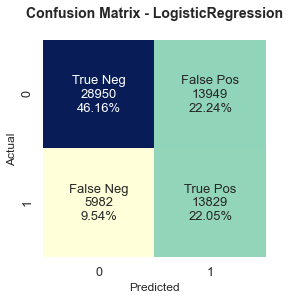



 Reporting for GaussianNB:



,model_name,train_time,pred_time,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test
1,GaussianNB,0.53,1.47,0.59,0.48,0.56,0.36,0.85,0.85



Classification Report for GaussianNB :

               precision    recall  f1-score   support

           0       0.82      0.31      0.45     42899
           1       0.36      0.85      0.51     19811

    accuracy                           0.48     62710
   macro avg       0.59      0.58      0.48     62710
weighted avg       0.67      0.48      0.47     62710



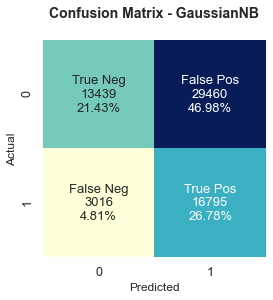



 Reporting for XGBClassifier:



,model_name,train_time,pred_time,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test
2,XGBClassifier,176.57,1.70,0.66,0.60,0.62,0.43,0.82,0.82



Classification Report for XGBClassifier :

               precision    recall  f1-score   support

           0       0.86      0.50      0.63     42899
           1       0.43      0.82      0.57     19811

    accuracy                           0.60     62710
   macro avg       0.65      0.66      0.60     62710
weighted avg       0.72      0.60      0.61     62710



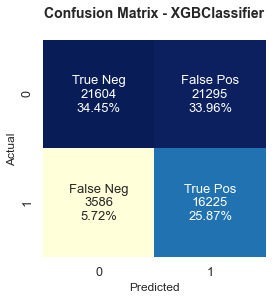



 Reporting for RandomForestClassifier:



,model_name,train_time,pred_time,acc_train,acc_test,precision_train,precision_test,recall_train,recall_test
3,RandomForestClassifier,21.84,1.69,0.68,0.69,0.69,0.50,0.66,0.66



Classification Report for RandomForestClassifier :

               precision    recall  f1-score   support

           0       0.82      0.70      0.76     42899
           1       0.50      0.66      0.57     19811

    accuracy                           0.69     62710
   macro avg       0.66      0.68      0.66     62710
weighted avg       0.72      0.69      0.70     62710



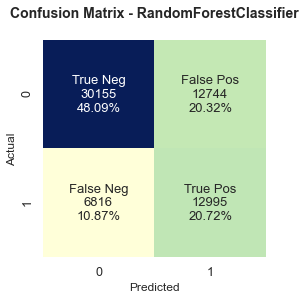

In [32]:
mdl.ml_reporting(results_list, predicted_target_values_list)

In several experiments different combinations of scaling and balancing strategies have been tested (focusing on the logistic regression as the benchmark model, which the ZEIT has implemented at the moment). Investigated combinations are as follow:

Scaling Strategie | Balancing Strategie
----------------- | -----------------
Unscaled | Unbalanced
MinMaxScaler | RandomOverSampling
MinMaxScaler | RandomUnderSampling
StandardScaler | RandomOverSampling
StandardScaler | RandomUnderSampling


As a result the combination of **StandardScaler** and **RandomUnderSampling** gives the best balance between recall and percision as well as the best accuracy.

### **Exporting Results**

In [35]:
#mdl.ml_reporting_exp_figs(results_list, predicted_target_values_list, PATH)

LogisticRegression exported.
GaussianNB exported.
XGBClassifier exported.
RandomForestClassifier exported.


In [36]:
#mdl.ml_reporting_exp_tables(results_list, predicted_target_values_list, PATH)